# Stacking of models into two layers
1. First layer: train models on the whole training set
2. Second layer: train a model on the first layer's predictions and the rest of the training set

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
import lightgbm as lgb
import pandas as pd

from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


%pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Configure running

In [ ]:
load_xgb: bool = False
load_lgb: bool = False
load_cat: bool = False
load_rf: bool = False

## Get the data

In [6]:
X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,6.450,1.25900,902436.125,194.449997,2426.750000,0.0,277.625000,88.175003,348536.406250,70.375000,271995.531250,62.900002,1.0,0.0,0.0000,0.00,1018.400024,0.0,0.0,58.174999,242.404755,0.000,281.774994,100.000000,43816.324219,0.725,-0.250,-0.700,0.0,1,0,0,0.984306,0.176471,-0.707107,-0.707107,6205.315918,0.242142,0.301401,0,0.629000,1,158.550003,0,0,0
1,4.925,1.27550,0.000,0.000000,971.250000,0.0,273.600006,0.000000,0.000000,0.000000,0.000000,99.425003,0.0,1.0,0.0000,0.00,1010.150024,0.0,0.0,73.949997,309.972748,0.100,276.625000,99.425003,33486.976562,2.825,1.125,2.600,0.0,1,0,0,-0.702148,0.712031,-0.866025,0.500000,0.000000,0.000000,0.000000,0,1.000000,1,0.000000,0,0,0
2,6.975,1.20350,797556.125,175.350006,3255.375000,0.0,279.075012,50.824997,206314.859375,120.599998,537617.250000,5.250000,1.0,0.0,0.0000,0.00,995.099976,0.0,0.0,45.700001,230.077255,0.000,289.299988,6.050000,57556.351562,4.925,-0.275,4.925,0.0,0,1,0,-0.999371,0.035473,-0.500000,-0.866025,6129.494629,0.226685,0.674081,0,0.867769,0,171.424988,0,0,0
3,4.675,1.23925,0.000,0.000000,2067.925049,0.0,272.924988,0.000000,0.000000,0.000000,0.000000,91.949997,0.0,1.0,0.0000,0.00,981.574951,0.0,0.0,65.949997,252.160492,0.000,279.774994,98.974998,45661.750000,3.800,1.100,3.625,0.0,1,0,0,-0.638384,0.769718,-0.866025,-0.500000,0.000000,0.000000,0.000000,0,0.929022,1,0.000000,0,0,0
4,9.450,1.22500,2240127.750,591.500000,115.849998,0.0,283.324982,138.100006,454697.093750,66.150002,185963.796875,96.349998,1.0,0.0,0.0125,0.25,1001.400024,0.0,0.0,88.900002,216.283997,0.275,284.000000,98.199997,5958.750000,4.525,4.100,-1.950,0.0,0,0,1,-0.739392,-0.673275,-0.258819,-0.965926,9135.315430,0.571108,0.083015,0,0.981161,1,204.250000,0,0,1


## Train test split for the base layer and meta layer

In [7]:
# The base layer gets 80% of the data
# The meta layer gets 20% of the data
base_to_meta_layer_split = 0.8

base_x_train = x_whole.sample(frac=base_to_meta_layer_split)
meta_x_train = x_whole.sample(frac=1-base_to_meta_layer_split)

# Get the corresponding y values
base_y_train = y_whole[base_x_train.index]
meta_y_train = y_whole[meta_x_train.index]
base_x_train.columns

Index(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m',
       'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx',
       'precip_5min:mm', 'precip_type_5min:idx', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'location_a', 'location_b', 'location_c', 'sin_day_of_year',
       'cos_day_of_year', 'sin_hour', 'cos_hour', 'sun_product',
       'modified_solar_elevation', 'effective_radiation',
       'time_since_prediction', 'cloud_ratio', 'cloud_cover_over_30%',
       'sun_addition', 'is_freezing', 'is_snow', 'is_rain

# Train Base level models
It is important to use a variety of models to get a diverse set of predictions.

I want a model to check if there is a linear relationship between the location features and the target. I will use a linear regression model for this.
I want to check if the different irradiation values are correlated with the target. I will use xgboost for this.
I want to check if the different temperature values are correlated with the target. I will use 


## XGBoost

In [8]:
# K-fold cross validation
if load_xgb:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    xgboost_models = []


    for train_index, test_index in kf.split(base_x_train):
        reg = xgb.XGBRegressor(n_estimators=10000000,
                        early_stopping_rounds=50,
                        learning_rate= 0.001,
                        objective="reg:linear",
                        eval_metric="mae",
                        sub_sample = 0.9,
                        colsample_bytree = 1.0,
                        gamma = 0,
                        min_child_weight=0,
                        max_depth=9)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Create sample weights for training data
        sample_weight_train = np.where(X_train['time_since_prediction'] == 0, 1, 2)
        # Create sample weights for testing data
        sample_weight_test = np.where(X_test['time_since_prediction'] == 0, 1, 2)
        
        reg.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                sample_weight=sample_weight_train,
                sample_weight_eval_set=[sample_weight_test],  # Here's how you pass the eval weights
                verbose=100)
        
        xgboost_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions, sample_weight=sample_weight_test)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

[0]	validation_0-mae:457.34673
[100]	validation_0-mae:416.63755
[200]	validation_0-mae:380.11439
[300]	validation_0-mae:347.36942
[400]	validation_0-mae:318.34896
[500]	validation_0-mae:292.76028
[600]	validation_0-mae:270.15887
[700]	validation_0-mae:250.14122
[800]	validation_0-mae:232.39713
[900]	validation_0-mae:216.63806
[1000]	validation_0-mae:202.63497
[1100]	validation_0-mae:190.22722
[1200]	validation_0-mae:179.29625
[1300]	validation_0-mae:169.63634
[1400]	validation_0-mae:161.10339
[1500]	validation_0-mae:153.56411
[1600]	validation_0-mae:146.86240
[1700]	validation_0-mae:140.93383
[1800]	validation_0-mae:135.65059
[1900]	validation_0-mae:130.93691
[2000]	validation_0-mae:126.66437
[2100]	validation_0-mae:122.82734
[2200]	validation_0-mae:119.36699
[2300]	validation_0-mae:116.23622
[2400]	validation_0-mae:113.45280
[2500]	validation_0-mae:111.00579
[2600]	validation_0-mae:108.78737
[2700]	validation_0-mae:106.79485
[2800]	validation_0-mae:104.95425
[2900]	validation_0-mae:10

## Catboost

In [ ]:
if not load_cat:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0
    catboost_models = []

    def compute_sample_weight(data):
        # Assign weight of 2 for estimated data and 1 for observed data
        return np.where(data['time_since_prediction'] > 0, 2, 1)

    for train_index, test_index in kf.split(base_x_train):
        reg = CatBoostRegressor(
            iterations=10000000,
            depth=8,
            learning_rate=0.001,
            loss_function='MAE',
            verbose=200
        )
        
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]
        
        # Compute sample weights for training and testing data
        train_weight = compute_sample_weight(X_train)
        test_weight = compute_sample_weight(X_test)

        # Create Pool for training and testing
        train_pool = Pool(data=X_train, label=y_train, weight=train_weight)
        test_pool = Pool(data=X_test, label=y_test, weight=test_weight)

        # Fit the model using the sample weights
        reg.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

        catboost_models.append(reg)
        predictions = reg.predict(test_pool)
        
        # Compute weighted MAE manually
        weighted_mae = np.sum(test_weight * np.abs(y_test - predictions)) / np.sum(test_weight)
        total_mae += weighted_mae
        
        print(f"Fold {len(catboost_models)}, Weighted Mean Absolute Error: {weighted_mae}")

    average_mae = total_mae / num_folds
    print(f"Average Weighted Mean Absolute Error: {average_mae}")


0:	learn: 319.2688617	test: 321.1561406	best: 321.1561406 (0)	total: 215ms	remaining: 24d 22h 21m 36s
200:	learn: 281.2586358	test: 283.0927042	best: 283.0927042 (200)	total: 7.5s	remaining: 4d 7h 41m 23s
400:	learn: 244.6701513	test: 246.4584006	best: 246.4584006 (400)	total: 14.4s	remaining: 4d 3h 51m 13s
600:	learn: 212.8658236	test: 214.8102130	best: 214.8102130 (600)	total: 21.7s	remaining: 4d 4h 16m 22s
800:	learn: 188.1097963	test: 190.2060282	best: 190.2060282 (800)	total: 28.3s	remaining: 4d 1h 58m 36s
1000:	learn: 168.8386292	test: 171.0407055	best: 171.0407055 (1000)	total: 35.3s	remaining: 4d 1h 59m 56s
1200:	learn: 154.1245236	test: 156.1806167	best: 156.1806167 (1200)	total: 42.7s	remaining: 4d 2h 49m 53s
1400:	learn: 142.5459343	test: 144.5358448	best: 144.5358448 (1400)	total: 49.6s	remaining: 4d 2h 22m 56s
1600:	learn: 133.2908509	test: 135.3052315	best: 135.3052315 (1600)	total: 56.9s	remaining: 4d 2h 41m 56s
1800:	learn: 125.5303259	test: 127.5529840	best: 127.552984

## lightgbm

In [ ]:
if not load_lgb:
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    total_mae = 0

    lightgbm_models = []

    params = {
        'objective': 'regression_l1',
        'boosting_type': 'gbdt',
        'max_depth': 8,
        'metric': 'mae',
        'num_leaves': 256,
        'learning_rate': 0.001,
        'feature_fraction': 1.0,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'min_data_in_leaf': 20,
        'early_stopping_rounds': 100,
        'verbosity': 100,  # 0 for verbose, -1 for silent
    }

    num_round = 10000000 # number of training iterations

    # Ensure column names are compatible with LightGBM
    base_x_train.columns = base_x_train.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

    for train_index, test_index in kf.split(base_x_train):
        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_test, label=y_test)

        reg = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
        lightgbm_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.883147
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.368057
[LightGBM] [Debug] init for col-wise cost 0.003511 seconds, init for row-wise cost 0.011434 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 7461
[LightGBM] [Info] Number of data points in the train set: 49320, number of used features: 45
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Debug] Re-bagging, using 44391 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 114 and depth = 8
[1]	valid_0's l1: 320.904
Training until validation scores don't improve for 100 rounds
Did not meet 

## Random Forest

In [ ]:
if not load_rf:
    # K-fold cross validation
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    total_mae = 0

    random_forest_models = []


    for train_index, test_index in kf.split(base_x_train):

        rf_model = RandomForestRegressor(n_estimators=1, random_state=42)

        X_train, X_test = base_x_train.iloc[train_index], base_x_train.iloc[test_index]
        y_train, y_test = base_y_train.iloc[train_index], base_y_train.iloc[test_index]

        # Train the Random Forest model on the cleaned training data
        
        reg.fit(X_train, y_train,
                eval_set=[(X_val_est_combined, y_val_est_combined)],
                verbose=100)
        
        random_forest_models.append(reg)
        predictions = reg.predict(X_test)
        
        mae = mean_absolute_error(y_test, predictions)
        total_mae += mae
        
        print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

    average_mse = total_mae / num_folds
    print(f"Average Mean Squared Error: {average_mse}")

### load the models

In [ ]:
# Check what models should be loaded
# Load XGBoost models
if load_xgb:
    with open("xgboost_models.pkl", "rb") as file:
        xgboost_models = pickle.load(file)

# Load CatBoost models
if load_cat:
    with open("catboost_models.pkl", "rb") as file:
        catboost_models = pickle.load(file)
# Load lightGBM models
if load_lgb:
    with open("lightgbm_models.pkl", "rb") as file:
        lightgbm_models = pickle.load(file)
# Load random forest models
if load_rf:
    with open("random_forest_models.pkl", "rb") as file:
        random_forest_models = pickle.load(file)


In [ ]:
def average_prediction(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        model: xgb.XGBRegressor
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return results


# Train meta learner model

Create dataset for meta learner model by using models to predict on the meta layer training set

In [ ]:
# Predict on the base layer on meta_x_train
base_xgboost_predictions  = average_prediction(meta_x_train, xgboost_models)
base_catboost_predictions = average_prediction(meta_x_train, catboost_models)
base_lightgbm_predictions = average_prediction(meta_x_train, lightgbm_models)
base_random_forest_predictions = average_prediction(meta_x_train, random_forest_models)

# Add the predictions to the meta_x_train
meta_base_x_train = pd.DataFrame()
meta_base_x_train["xgboost"] = base_xgboost_predictions
meta_base_x_train["catboost"] = base_catboost_predictions
meta_base_x_train["lightgbm"] = base_lightgbm_predictions
meta_x_train["random_forest"] = base_random_forest_predictions



Train meta learner model on new dataset

In [ ]:
# K-fold cross validation

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

total_mae = 0

meta_models = []


for train_index, test_index in kf.split(meta_base_x_train):

    reg = xgb.XGBRegressor(n_estimators=100000,
                       early_stopping_rounds=50,
                       learning_rate= 0.01,
                       objective="reg:linear",
                       eval_metric="mae",
                       sub_sample = 0.9,
                       colsample_bytree = 0.8,
                       gamma = 0,
                       alpha = 0.001,
                       min_child_weight=0,
                       max_depth=4)

    X_train, X_test = meta_base_x_train.iloc[train_index], meta_base_x_train.iloc[test_index]
    y_train, y_test = meta_y_train.iloc[train_index], meta_y_train.iloc[test_index]

    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=100)
    
    meta_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

[0]	validation_0-mae:437.81923


Fold 437.81923520276587, Mean Absolute Error: 437.81923520276587
[0]	validation_0-mae:469.82864
Fold 907.6478779289748, Mean Absolute Error: 469.828642726209
[0]	validation_0-mae:442.07283
Fold 1349.7207061602815, Mean Absolute Error: 442.0728282313066
[0]	validation_0-mae:462.35442
Fold 1812.075125533751, Mean Absolute Error: 462.35441937346957
[0]	validation_0-mae:442.78670
Fold 2254.8618256781283, Mean Absolute Error: 442.7867001443772
Average Mean Squared Error: 450.97236513562564


<Figure size 10000x10000 with 0 Axes>

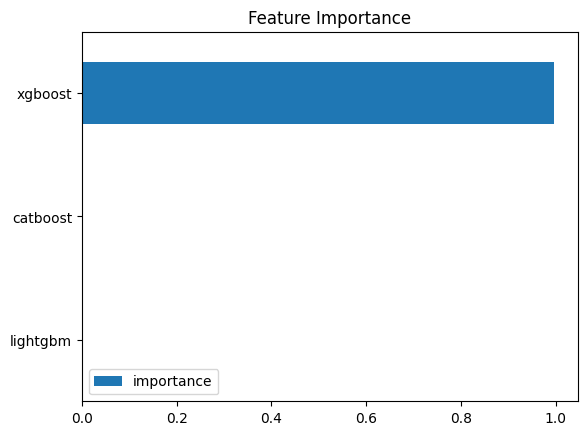

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=["importance"])

plt.figure(figsize=(100,100))
plt.tight_layout()
fi.sort_values("importance").plot(kind="barh", title="Feature Importance")
plt.show()

In [ ]:
y_pred_val_obs_combined = average_prediction(X_val_obs_combined, meta_models)
y_pred_val_est_combined = average_prediction(X_val_est_combined, meta_models)

# Evaluate the model's performance using Mean Absolute Error (MAE) on the combined validation observed data
mae_obs_combined = mean_absolute_error(y_val_obs_combined, y_pred_val_obs_combined)
mae_est_combined = mean_absolute_error(y_val_est_combined, y_pred_val_est_combined)
print('MAE on validation observed data: ', mae_obs_combined)
print('MAE on validation estimated data: ', mae_est_combined)


ValueError: feature_names mismatch: ['xgboost', 'catboost', 'lightgbm'] ['absolute_humidity_2m:gm3', 'air_density_2m:kgm3', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J', 'effective_cloud_cover:p', 'is_day:idx', 'is_in_shadow:idx', 'precip_5min:mm', 'precip_type_5min:idx', 'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sun_azimuth:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms', 'location_a', 'location_b', 'location_c', 'sin_day_of_year', 'cos_day_of_year', 'sin_hour', 'cos_hour', 'sun_product', 'modified_solar_elevation', 'effective_radiation', 'time_since_prediction', 'cloud_ratio', 'cloud_cover_over_30%', 'sun_addition', 'is_freezing', 'is_snow', 'is_rain']
expected catboost, xgboost, lightgbm in input data
training data did not have the following fields: effective_radiation, precip_type_5min:idx, sin_day_of_year, diffuse_rad_1h:J, location_b, location_c, cos_hour, cloud_cover_over_30%, is_rain, rain_water:kgm2, clear_sky_rad:W, wind_speed_10m:ms, air_density_2m:kgm3, t_1000hPa:K, absolute_humidity_2m:gm3, diffuse_rad:W, sun_product, relative_humidity_1000hPa:p, prob_rime:p, wind_speed_u_10m:ms, precip_5min:mm, effective_cloud_cover:p, sin_hour, cloud_base_agl:m, direct_rad:W, direct_rad_1h:J, dew_point_2m:K, wind_speed_w_1000hPa:ms, pressure_50m:hPa, cloud_ratio, wind_speed_v_10m:ms, dew_or_rime:idx, is_freezing, is_day:idx, location_a, is_snow, visibility:m, cos_day_of_year, is_in_shadow:idx, total_cloud_cover:p, time_since_prediction, sun_addition, clear_sky_energy_1h:J, modified_solar_elevation, super_cooled_liquid_water:kgm2, sun_azimuth:d

## Get predictions for meta learner model test set

In [ ]:
# Predict on the cleaned validation set
from src.features.preprocess_data import get_final_prediction

y_predictions = average_prediction(x_test_whole, meta_models)

## Save predictions

In [ ]:
from src.models.saving import save_predictions


save_predictions(y_predictions, 'stacking with possible data leakage')